# **1. Loading Data**

In [160]:
pip install fastf1 matplotlib pandas numpy seaborn bar_chart_race geopandas --quiet

In [161]:
import os
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
import bar_chart_race as bcr
import plotly.express as px

# Ensure cache directory exists
if not os.path.exists("cache"):
    os.makedirs("cache")

# Enable caching for faster data loading
fastf1.Cache.enable_cache('cache')

In [162]:
results = pd.read_csv("winners.csv")
drivers = pd.read_csv("drivers_updated.csv")
fastest_laps = pd.read_csv("fastest_laps_updated.csv")
teams = pd.read_csv("teams_updated.csv")

In [163]:
results.sample(10)

,Grand Prix,Date,Winner,Car,Laps,Time,Name Code
985,Canada,2018-06-10,Sebastian Vettel,Ferrari,68.0,1:28:31.377,VET
532,Portugal,1992-09-27,Nigel Mansell,Williams Renault,71.0,1:34:46.659,MAN
791,Spain,2008-04-27,Kimi RÃ¤ikkÃ¶nen,Ferrari,66.0,1:38:19.051,RAI
717,Malaysia,2004-03-21,Michael Schumacher,Ferrari,56.0,1:31:07.490,MSC
937,Abu Dhabi,2015-11-29,Nico Rosberg,Mercedes,55.0,1:38:30.175,ROS
490,Monaco,1990-05-27,Ayrton Senna,McLaren Honda,78.0,1:52:46.982,SEN
901,Malaysia,2014-03-30,Lewis Hamilton,Mercedes,56.0,1:40:25.974,HAM
556,Canada,1994-06-12,Michael Schumacher,Benetton Ford,69.0,1:44:31.887,MSC
142,United States,1965-10-03,Graham Hill,BRM,110.0,2:20:36.100,HIL
94,Portugal,1960-08-14,Jack Brabham,Cooper Climax,55.0,2:19:00.030,BRA


In [164]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Grand Prix  1110 non-null   object 
 1   Date        1110 non-null   object 
 2   Winner      1110 non-null   object 
 3   Car         1110 non-null   object 
 4   Laps        1107 non-null   float64
 5   Time        1107 non-null   object 
 6   Name Code   1110 non-null   object 
dtypes: float64(1), object(6)
memory usage: 60.8+ KB


In [165]:
results.shape

(1110, 7)

# **2. Pre-processing Data**

In [51]:
results['Date'] = pd.to_datetime(results['Date'])
results['Year'] = results['Date'].dt.year
results['Month'] = results['Date'].dt.month

In [52]:
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
results['Month'] = results['Month'].map(month_dict)

In [53]:
hr = []
min = []
sec = []

for i in results['Time']:
    if i is not np.nan:
        if len(i.split(':')) != 3:
            hr.append(0)
            min.append(int(i.split(':')[0]))
            sec.append(float(i.split(':')[1]))
        else:
            hr.append(int(i.split(':')[0]))
            min.append(int(i.split(':')[1]))
            sec.append(float(i.split(':')[2]))
    else:
        hr.append(np.nan)
        min.append(np.nan)
        sec.append(np.nan)

In [54]:
results['Hours'] = hr
results['Minutes'] = min
results['Seconds'] = sec

In [55]:
results['Total Time in Seconds'] = results['Hours'] * 3600 + results['Minutes'] * 60 + results['Seconds']

In [56]:
results['Average Time per lap'] = results['Total Time in Seconds']/results['Laps']

# **3. Visualising Data**

### **Part 1: Analysing Races and Race Winners for the past 50 Years**

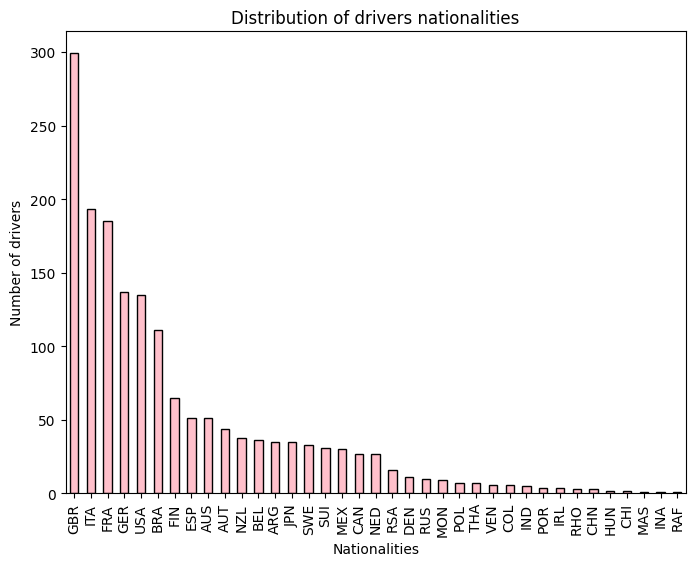

In [60]:
plt.figure(figsize=(8, 6))
drivers['Nationality'].value_counts().plot(kind='bar', color='pink', edgecolor='black')
plt.title('Distribution of drivers nationalities')
plt.xlabel('Nationalities')
plt.ylabel('Number of drivers')
plt.show()

<ipython-input-61-ab9c3b08a6ba>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




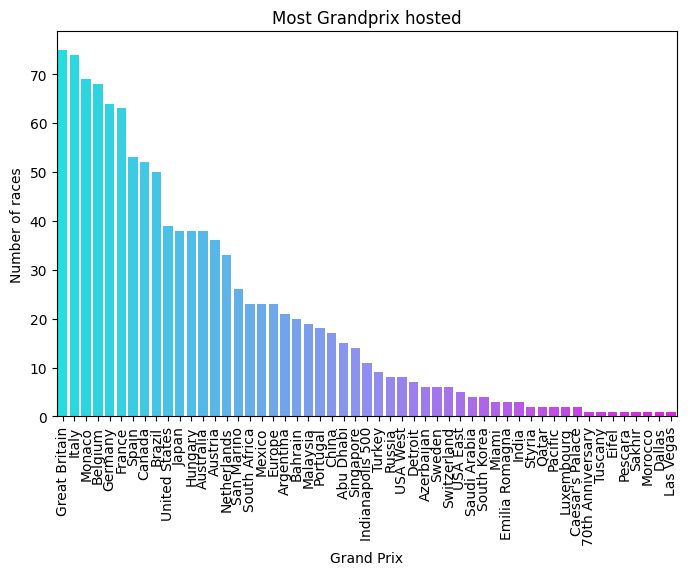

In [61]:
plt.figure(figsize=(8,5))
sns.countplot(data = results, x = 'Grand Prix', order=results['Grand Prix'].value_counts().index, palette="cool")
plt.xticks(rotation = 90)
plt.title('Most Grandprix hosted')
plt.ylabel('Number of races')
plt.xlabel('Grand Prix')
plt.show()

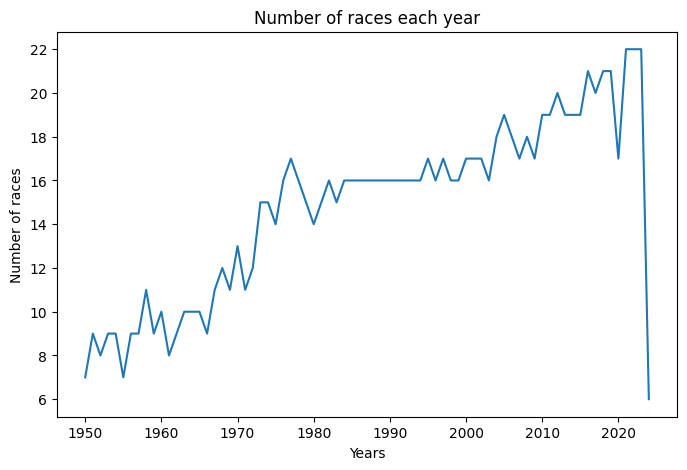

In [62]:
years =results['Year'].value_counts()
plt.figure(figsize=(8,5))
sns.lineplot(years)
plt.title('Number of races each year')
plt.xlabel('Years')
plt.ylabel('Number of races')
plt.show()

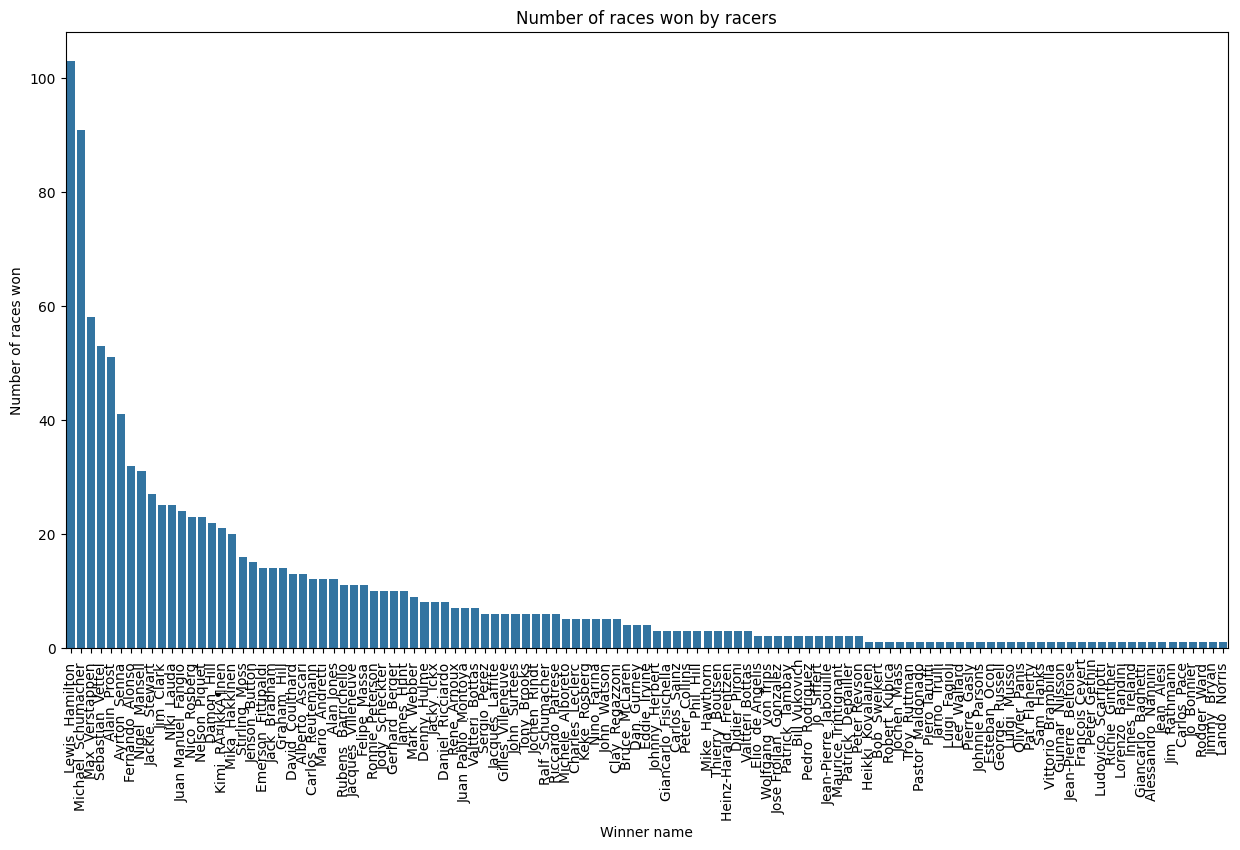

In [63]:
plt.figure(figsize=(15,8))
sns.countplot(data = results, x = 'Winner', order=results['Winner'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Number of races won by racers')
plt.ylabel('Number of races won')
plt.xlabel('Winner name')
plt.show()

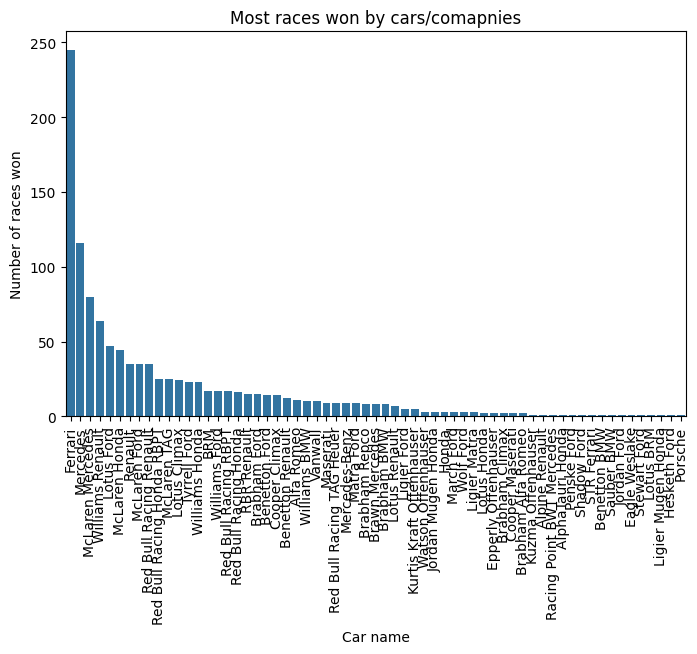

In [64]:
plt.figure(figsize=(8,5))
sns.countplot(data = results, x = 'Car', order=results['Car'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Most races won by cars/comapnies')
plt.ylabel('Number of races won')
plt.xlabel('Car name')
plt.show()

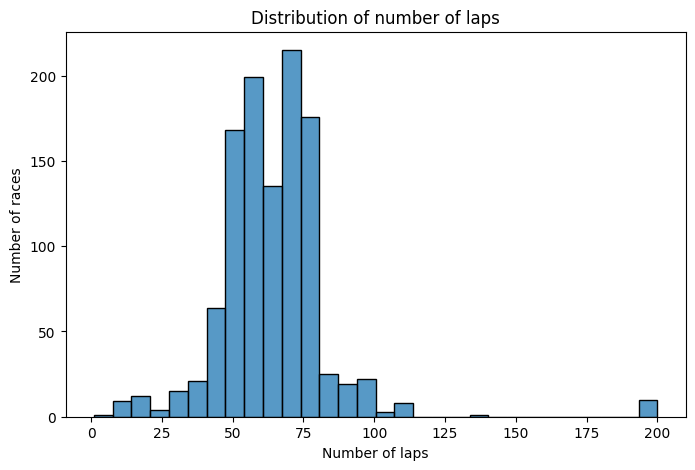

In [65]:
plt.figure(figsize=(8,5))
sns.histplot(data = results, x = 'Laps', bins = 30)
plt.title('Distribution of number of laps')
plt.ylabel('Number of races')
plt.xlabel('Number of laps')
plt.show()

In [66]:
# Group the drivers according to thier respective points tally from f1_drivers dataset
f1_points = drivers.groupby('Driver').agg(total=('PTS', sum)).reset_index()
f1_points = f1_points.sort_values('total', ascending=False).head(20)

# Create a histogram of the points tally
fig = px.histogram(f1_points, x='Driver',y='total',
                   color='total')
fig.update_layout(
    title='Drivers score ranking',
    xaxis_title='Drivers',
    yaxis_title='Total')

fig.show()


<ipython-input-66-ac5267382be4>:2: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



<ipython-input-67-df580cd75025>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




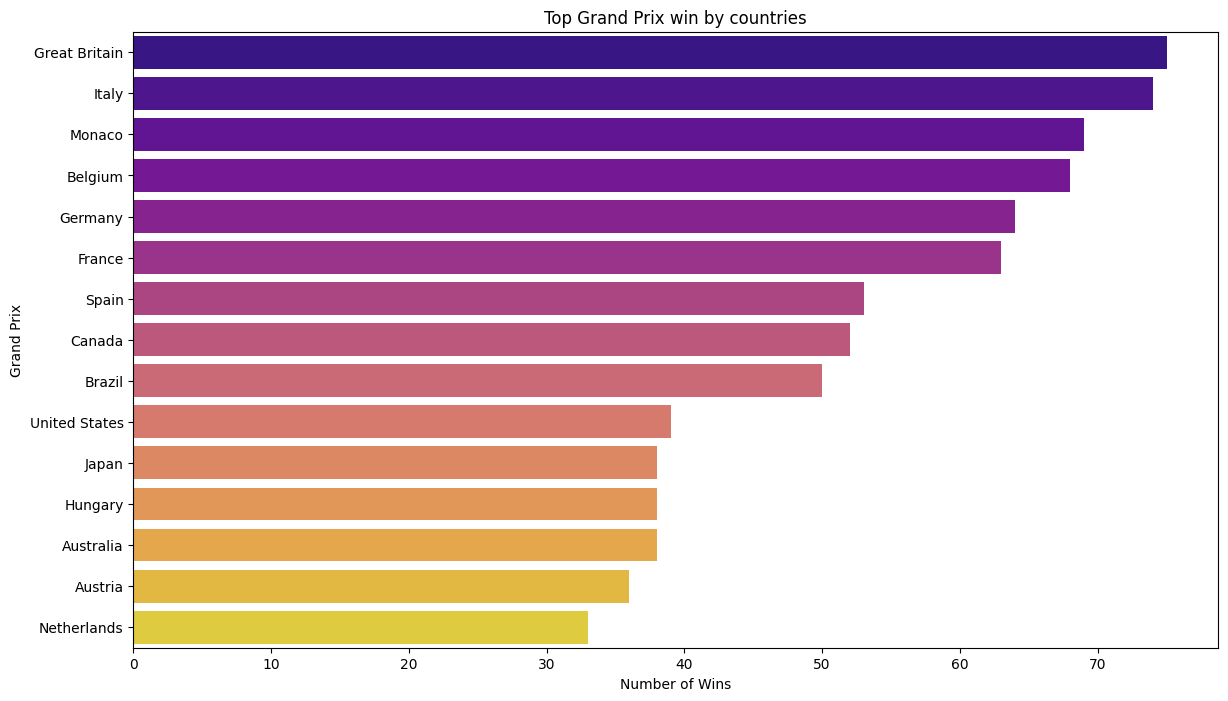

In [67]:
# Group grand prix wins according to countries
top_grand_prix_wins = results.groupby("Grand Prix").size().reset_index(name="count").sort_values("count",ascending=False).head(15)

# create a barplot
plt.figure(figsize=(14, 8))
sns.barplot(x="count", y="Grand Prix", data=top_grand_prix_wins, palette="plasma")


plt.xlabel("Number of Wins")
plt.ylabel("Grand Prix")
plt.title("Top Grand Prix win by countries")
plt.show()

In [68]:
import geopandas as gpd
import plotly.express as px

# Step 2: Count the number of drivers by nationality
driver_counts = drivers['Nationality'].value_counts().reset_index()
driver_counts.columns = ['Nationality', 'Count']

# Step 3: Map nationalities to country names
nationality_to_country = {
    'BRA': 'Brazil',
    'SWE': 'Sweden',
    'GBR': 'United Kingdom',
    'ITA': 'Italy',
    'FRA': 'France',
    'GER': 'Germany',
    'USA': 'United States',
    'AUS': 'Australia',
    'CAN': 'Canada',
    'JPN': 'Japan',
    'ESP': 'Spain',
    'NED': 'Netherlands',
    'ARG': 'Argentina',
    'FIN': 'Finland',
    'AUT': 'Austria',
    'NZL': 'New Zealand',
    'BEL': 'Belgium',
    'SUI': 'Switzerland',
    'MEX': 'Mexico',
    'RSA': 'South Africa',
    'DEN': 'Denmark',
    'RUS': 'Russia',
    'MON': 'Monaco',
    'POL': 'Poland',
    'THA': 'Thailand',
    'VEN': 'Venezuela',
    'COL': 'Colombia',
    'IND': 'India',
    'POR': 'Portugal',
    'IRL': 'Ireland',
    'RHO': 'Rhodesia',
    'CHN': 'China',
    'HUN': 'Hungary',
    'CHI': 'Chile',
    'MAS': 'Malaysia',
    'INA': 'Indonesia'}

# Apply the mapping to convert nationalities to country names
driver_counts['Country'] = driver_counts['Nationality'].map(nationality_to_country)

# Load the world map
world = gpd.read_file("ne_110m_admin_0_countries.shp")
print(world.columns)

# Merge driver counts with the world map
world = world.merge(driver_counts, how="left", left_on="NAME", right_on="Country")

# Plot the map
fig = px.choropleth(world,
                    locations='ISO_A3',
                    color='Count',
                    hover_name='Country',
                    hover_data=['Count'],
                    projection='natural earth',
                    title='Racing Nations: A World of Formula 1 Drivers',
                    color_continuous_scale='pinkyl')

# Customize the map style
fig.update_geos(
    visible=False,
    showcountries=True,
    countrycolor="White",
    coastlinecolor="White",
    showland=True,
    landcolor="LightGrey",
    showocean=True,
    oceancolor="LightBlue",
    showlakes=True,
    lakecolor="LightBlue",
    showrivers=True,
    rivercolor="LightBlue"
)

# Add subtitle and data source
fig.update_layout(
    title={
        'text': "Racing Nations: A World of Formula 1 Drivers",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    annotations=[
        dict(
            text="Number of Drivers by Nationality Worldwide",
            xref="paper",
            yref="paper",
            x=0.5,
            y=-0.25,
            showarrow=False,
            font=dict(
                family="Arial",
                size=12,
                color="grey"
            )
        )
    ]
)

# Show the plot
fig.show()

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


### **Part 2: Analysing A Specific Race - the Drivers and their Strategies**

In [69]:
# Load race data (Choose a specific race - Year, Location, Session)
race = fastf1.get_session(2023, 'Singapore', 'R')
race.load()

if race is None:
    raise ValueError("Error: Race data not found. Check the event name and year.")

core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.0]
INFO:fastf1.fastf1.core:Loading data for Singapore Grand Prix - Race [v3.5.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

In [81]:
# Select drivers for comparison
drivers = ['VER', 'SAI']

# Get lap data for selected drivers
laps = race.laps[race.laps['Driver'].isin(drivers)]

# Ensure lap times are not null and convert to seconds
laps = laps.dropna(subset=['LapTime'])
laps['LapTime'] = laps['LapTime'].dt.total_seconds()

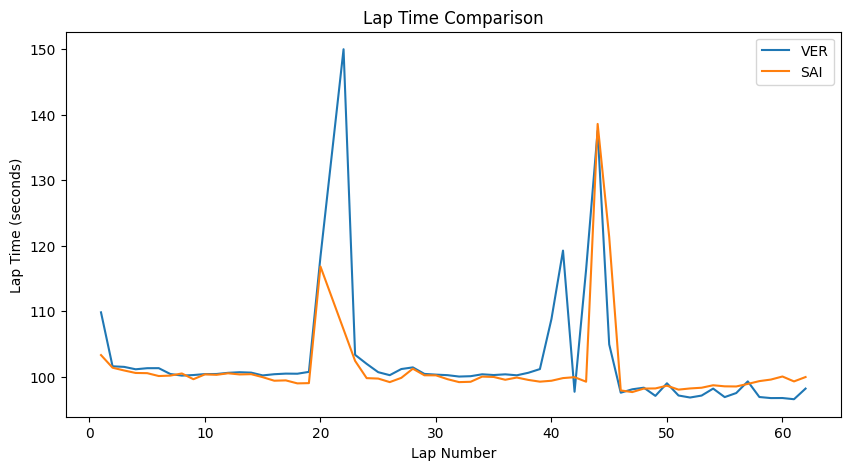

In [82]:
# Plot lap times
plt.figure(figsize=(10,5))
for driver in drivers:
    driver_laps = laps[laps['Driver'] == driver]
    plt.plot(driver_laps['LapNumber'], driver_laps['LapTime'], label=driver)

plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.title("Lap Time Comparison")
plt.legend()
plt.show()

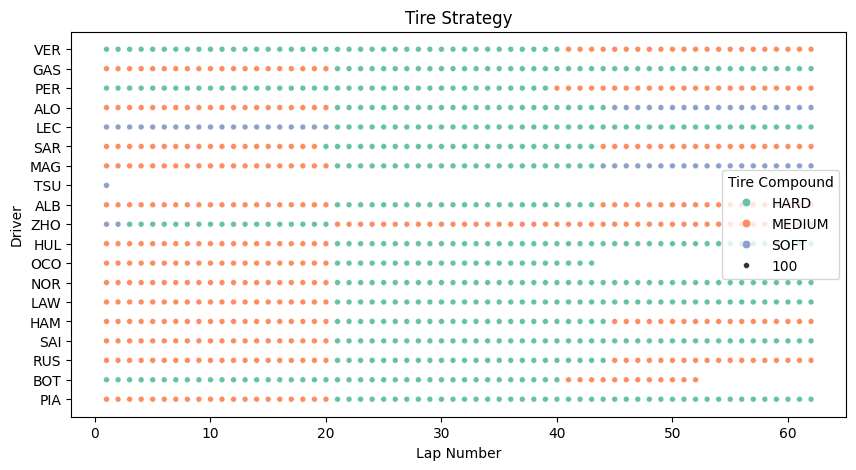

In [83]:
# Analyze Tire Strategies
pit_stops = race.laps[["Driver", "LapNumber", "Compound"]].drop_duplicates()
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pit_stops, x="LapNumber", y="Driver", hue="Compound", palette="Set2", size=100, legend="full")
plt.xlabel("Lap Number")
plt.ylabel("Driver")
plt.title("Tire Strategy")
plt.legend(title="Tire Compound")
plt.show()

In [84]:
# Overtakes Analysis
positions = race.laps[["LapNumber", "Driver", "Position"]].drop_duplicates()
positions['PositionChange'] = positions.groupby('Driver')['Position'].diff().fillna(0)
overtakes = positions[positions['PositionChange'] < 0]
overtakes

,LapNumber,Driver,Position,PositionChange
1,2.0,VER,9.0,-2.0
5,6.0,VER,8.0,-1.0
19,20.0,VER,6.0,-2.0
20,21.0,VER,2.0,-4.0
42,43.0,VER,13.0,-2.0
...,...,...,...,...
1064,39.0,PIA,10.0,-1.0
1066,41.0,PIA,9.0,-1.0
1068,43.0,PIA,8.0,-1.0
1069,44.0,PIA,7.0,-1.0


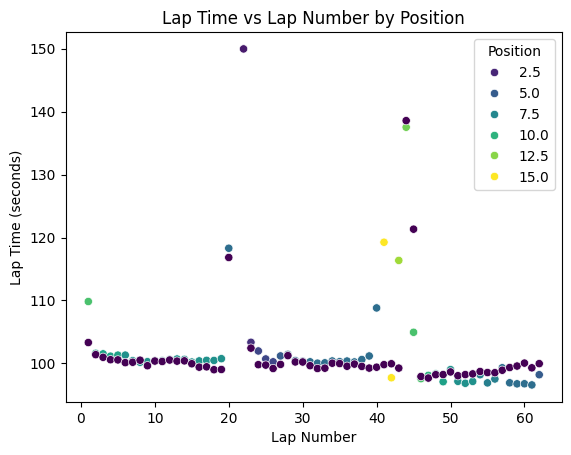

In [85]:
# Lap Time vs Position Analysis
sns.scatterplot(x=laps['LapNumber'], y=laps['LapTime'], hue=laps['Position'], palette='viridis')
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.title("Lap Time vs Lap Number by Position")
plt.show()

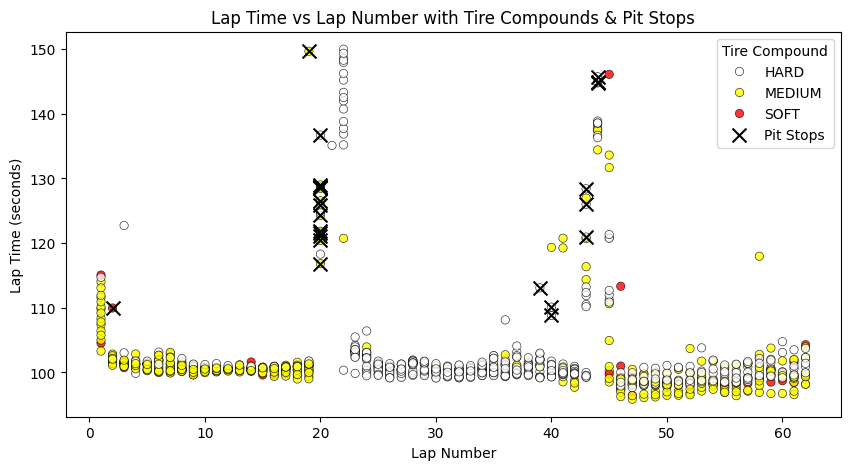

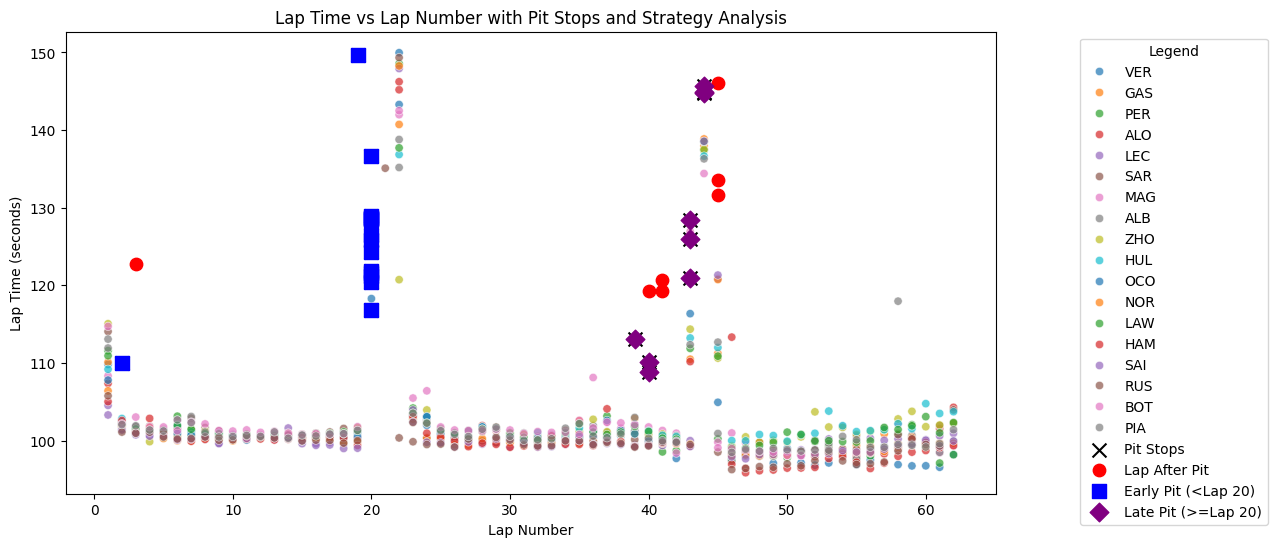

In [86]:
# Get lap data and convert lap time to seconds
laps = race.laps[['Driver', 'LapNumber', 'LapTime', 'Compound', 'Position']].dropna()
laps['LapTime'] = laps['LapTime'].dt.total_seconds()

# Extract pit stop lap numbers
pit_stops = race.laps[race.laps['PitInTime'].notna()][['Driver', 'LapNumber']]

# Merge to get lap times for pit stops
pit_stop_lap_times = pit_stops.merge(laps, on=['Driver', 'LapNumber'], how='left')

# Get lap times immediately after a pit stop (lap after pitting)
pit_stop_lap_times['PostPitLap'] = pit_stop_lap_times['LapNumber'] + 1
post_pit_laps = pit_stop_lap_times.merge(laps, left_on=['Driver', 'PostPitLap'],
                                          right_on=['Driver', 'LapNumber'],
                                          suffixes=('_Pit', '_PostPit'))

# Define color mapping for tire compounds
compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'yellow',
    'HARD': 'white',
    'INTERMEDIATE': 'green',
    'WET': 'blue'}

# Create the scatter plot
plt.figure(figsize=(10,5))
sns.scatterplot(data=laps, x="LapNumber", y="LapTime", hue="Compound", palette=compound_colors, edgecolor="black", alpha=0.8)

# Overlay pit stops with red "X" markers
plt.scatter(pit_stop_lap_times['LapNumber'], pit_stop_lap_times['LapTime'], color='black', marker='x', s=100, label="Pit Stops")

# Labels and title
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.title("Lap Time vs Lap Number with Tire Compounds & Pit Stops")
plt.legend(title="Tire Compound")
plt.show()

# Create the scatter plot for lap times
plt.figure(figsize=(12, 6))
sns.scatterplot(data=laps, x="LapNumber", y="LapTime", hue="Driver", palette="tab10", alpha=0.7)

# Overlay pit stops with "X" markers
plt.scatter(pit_stop_lap_times['LapNumber'], pit_stop_lap_times['LapTime'], color='black', marker='x', s=100, label="Pit Stops")

# Overlay post-pit lap times with "o" markers to track lap time drop
plt.scatter(post_pit_laps['LapNumber_PostPit'], post_pit_laps['LapTime_PostPit'], color='red', marker='o', s=80, label="Lap After Pit")

# Split early vs. late pit stops and visualize
early_pits = pit_stop_lap_times[pit_stop_lap_times['LapNumber'] < 30]
late_pits = pit_stop_lap_times[pit_stop_lap_times['LapNumber'] >= 30]

plt.scatter(early_pits['LapNumber'], early_pits['LapTime'], color='blue', marker='s', s=90, label="Early Pit (<Lap 20)")
plt.scatter(late_pits['LapNumber'], late_pits['LapTime'], color='purple', marker='D', s=90, label="Late Pit (>=Lap 20)")

# Labels and title
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.title("Lap Time vs Lap Number with Pit Stops and Strategy Analysis")
plt.legend(title="Legend", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()

# **4. Prediction**

**Goal** -  to predict the winner of an F1 race using historical race data. The model should consider factors like: Driver and car performance, Track characteristics, Weather conditions, Qualifying results, Pit strategies.

**Model** - Logistic Regression and Random Forest Model.

### Logistic Regression VS Random Forest Model
Outputs probability values instead of just binary classifications (0/1)

Less prone to overfitting compared to Random Forest, especially with small datasets

Easier to interpret (feature coefficients directly show impact on winning probability)

## Model 1: Logistic Regression

### **Step 1: Data Collection and PreProcessing**

In [148]:
import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fetch race data from the Ergast API
def fetch_race_data(year):
    url = f"http://ergast.com/api/f1/{year}/results.json?limit=1000"
    response = requests.get(url)
    data = response.json()

    race_results = []
    for race in data['MRData']['RaceTable']['Races']:
        race_name = race['raceName']
        round_num = race['round']
        circuit = race['Circuit']['circuitName']

        for result in race['Results']:
            driver = result['Driver']['code'] if 'code' in result['Driver'] else result['Driver']['familyName']
            constructor = result['Constructor']['name']
            grid_position = int(result['grid'])
            finishing_position = int(result['position'])
            points = float(result['points'])
            status = result['status']

            race_results.append([year, round_num, race_name, circuit, driver, constructor, grid_position, finishing_position, points, status])

    return pd.DataFrame(race_results, columns=['Year', 'Round', 'Race', 'Circuit', 'Driver', 'Constructor', 'Grid', 'Position', 'Points', 'Status'])

# Fetching data
years = list(range(2010, 2025))
all_race_data = [fetch_race_data(year) for year in years]
data = pd.concat(all_race_data, ignore_index=True)

### **Step 2: Model Training**

In [152]:
# Feature Engineering
data['Win'] = (data['Position'] == 1).astype(int)  # Target variable

data['Grid_Top5'] = (data['Grid'] <= 5).astype(int)  # Top 5 Grid Start Indicator

data['Constructor_Wins'] = data.groupby(['Constructor'])['Win'].transform('sum')  # Constructor Strength

data['Driver_Wins'] = data.groupby(['Driver'])['Win'].transform('sum')  # Driver Strength

data['Constructor_Points'] = data.groupby(['Constructor'])['Points'].transform('sum')  # Constructor Performance

data['Driver_Points'] = data.groupby(['Driver'])['Points'].transform('sum')  # Driver Performance

X = data[['Grid', 'Grid_Top5', 'Constructor_Wins', 'Driver_Wins']]
y = data['Win']

# Create a pipeline with feature scaling + Logistic Regression
log_reg_model = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))  # Handles class imbalance
])

# Train model
log_reg_model.fit(X, y)

# Predict probabilities on test set
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]

### **Step 3: Model Evaluation**

Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       287
           1       0.24      1.00      0.39        13

    accuracy                           0.86       300
   macro avg       0.62      0.93      0.66       300
weighted avg       0.97      0.86      0.90       300

Predicted Winner: VER
Actual Winner: SAI Incorrect

Predictions vs Actual Results for Australian Grand Prix
   Driver  Grid  Position  Predicted_Win_Prob
58    VER     1        19            0.623280
40    SAI     2         1            0.557400
42    NOR     3         3            0.428793
41    LEC     4         2            0.342936
43    PIA     5         4            0.254065
44    PER     6         5            0.150047
56    RUS     7        17            0.106275
46    TSU     8         7            0.074159
45    STR     9         6            0.051192
47    ALO    10         8            0.035068
57    HAM    11     

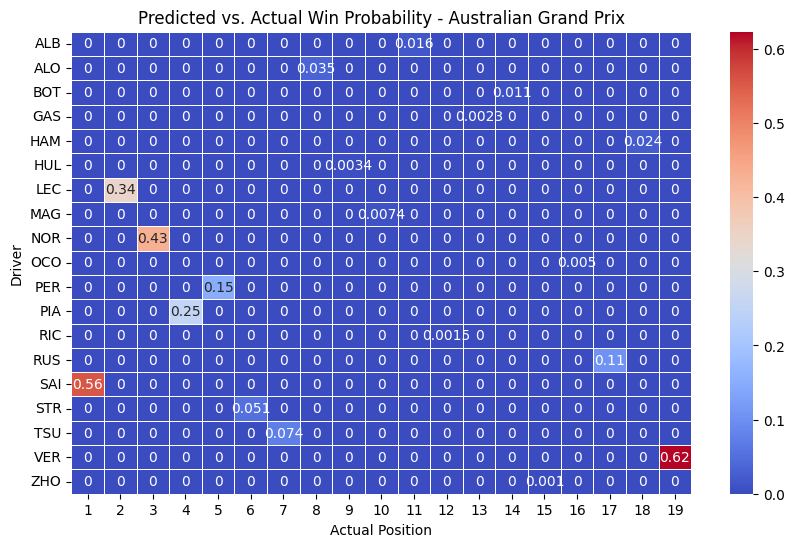

,Year,Round,Race,Circuit,Driver,Constructor,Grid,Position,Points,Status,Win,Grid_Top5,Constructor_Wins,Driver_Wins,Predicted_Win_Prob
58,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,VER,Red Bull,1,19,0.0,Brakes,0,1,0,0,0.623280
40,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,SAI,Ferrari,2,1,25.0,Finished,1,1,1,1,0.557400
42,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,NOR,McLaren,3,3,15.0,Finished,0,1,0,0,0.428793
41,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,LEC,Ferrari,4,2,19.0,Finished,0,1,1,0,0.342936
43,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,PIA,McLaren,5,4,12.0,Finished,0,1,0,0,0.254065
44,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,PER,Red Bull,6,5,10.0,Finished,0,0,0,0,0.150047
56,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,RUS,Mercedes,7,17,0.0,Accident,0,0,0,0,0.106275
46,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,TSU,RB F1 Team,8,7,6.0,Finished,0,0,0,0,0.074159
45,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,STR,Aston Martin,9,6,8.0,Finished,0,0,0,0,0.051192
47,2024,3,Australian Grand Prix,Albert Park Grand Prix Circuit,ALO,Aston Martin,10,8,4.0,Finished,0,0,0,0,0.035068


In [159]:
# Evaluate model
print("Logistic Regression Model Performance:")
print(classification_report(y_test, (y_pred_prob > 0.5).astype(int)))

# Function to test Logistic Regression on a specific race
def test_race_logistic(year, round_num):
    race_data = fetch_race_data(year)
    specific_race = race_data[race_data['Round'] == str(round_num)].copy()

    if specific_race.empty:
        print("Race data not found!")
        return

    # Ensure required features exist
    specific_race['Win'] = (specific_race['Position'] == 1).astype(int)
    specific_race['Grid_Top5'] = (specific_race['Grid'] <= 5).astype(int)
    specific_race['Constructor_Wins'] = specific_race.groupby(['Constructor'])['Win'].transform('sum')
    specific_race['Driver_Wins'] = specific_race.groupby(['Driver'])['Win'].transform('sum')

    X_race = specific_race[['Grid', 'Grid_Top5', 'Constructor_Wins', 'Driver_Wins']]

    # Predict probabilities using logistic regression
    predicted_probabilities = log_reg_model.predict_proba(X_race)[:, 1]

    # Assign probabilities to dataset
    specific_race['Predicted_Win_Prob'] = predicted_probabilities

    # Sort drivers by predicted win probability
    specific_race = specific_race.sort_values(by='Predicted_Win_Prob', ascending=False)

    predicted_winner = specific_race.iloc[0]['Driver']
    actual_winner = specific_race[specific_race['Win'] == 1]['Driver'].values[0]

    print(f"Predicted Winner: {predicted_winner}")
    print(f"Actual Winner: {actual_winner} {'Correct' if predicted_winner == actual_winner else 'Incorrect'}")

    print("\nPredictions vs Actual Results for", specific_race['Race'].iloc[0])
    print(specific_race[['Driver', 'Grid', 'Position', 'Predicted_Win_Prob']])

    # Heatmap visualization
    plt.figure(figsize=(10, 6))
    heatmap_data = specific_race.pivot(index='Driver', columns='Position', values='Predicted_Win_Prob').fillna(0)
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.xlabel("Actual Position")
    plt.ylabel("Driver")
    plt.title(f"Predicted vs. Actual Win Probability - {specific_race['Race'].iloc[0]}")
    plt.show()

    return specific_race

# Test Logistic Regression on a specific 2024 race
test_race_logistic(2024, 3)

## Model 2: RandomForestClassifier

### **Step 1: Data Collection**

In [133]:
import requests
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fetch race data from the Ergast API
def fetch_race_data(year):
    url = f"http://ergast.com/api/f1/{year}/results.json?limit=1000"
    response = requests.get(url)
    data = response.json()

    race_results = []
    for race in data['MRData']['RaceTable']['Races']:
        race_name = race['raceName']
        round_num = race['round']
        circuit = race['Circuit']['circuitName']

        for result in race['Results']:
            driver = result['Driver']['code'] if 'code' in result['Driver'] else result['Driver']['familyName']
            constructor = result['Constructor']['name']
            grid_position = int(result['grid'])
            finishing_position = int(result['position'])
            points = float(result['points'])
            status = result['status']

            race_results.append([year, round_num, race_name, circuit, driver, constructor, grid_position, finishing_position, points, status])

    return pd.DataFrame(race_results, columns=['Year', 'Round', 'Race', 'Circuit', 'Driver', 'Constructor', 'Grid', 'Position', 'Points', 'Status'])

# Fetching data
years = list(range(2010, 2025))
all_race_data = [fetch_race_data(year) for year in years]
data = pd.concat(all_race_data, ignore_index=True)

### **Step 2: Feature Engineering**

In [134]:
# Feature Engineering
data['Win'] = (data['Position'] == 1).astype(int)  # Target variable

data['Grid_Top5'] = (data['Grid'] <= 5).astype(int)  # Top 5 Grid Start Indicator

data['Constructor_Wins'] = data.groupby(['Constructor'])['Win'].transform('sum')  # Constructor Strength

data['Driver_Wins'] = data.groupby(['Driver'])['Win'].transform('sum')  # Driver Strength

data['Constructor_Points'] = data.groupby(['Constructor'])['Points'].transform('sum')  # Constructor Performance

data['Driver_Points'] = data.groupby(['Driver'])['Points'].transform('sum')  # Driver Performance

data['DNF'] = (data['Status'] != 'Finished').astype(int)

data['DNF_Rate'] = data.groupby('Driver')['DNF'].transform('mean')

# Splitting data into train and test
X = data[['Grid', 'Grid_Top5', 'Constructor_Wins', 'Driver_Wins']]
y = data['Win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Step 3: Model Selection & Training**

In [135]:
# Training Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on Test Data
y_pred = rf_model.predict(X_test)

### **Step 4: Model Evaluation**

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       287
           1       0.42      0.38      0.40        13

    accuracy                           0.95       300
   macro avg       0.69      0.68      0.69       300
weighted avg       0.95      0.95      0.95       300



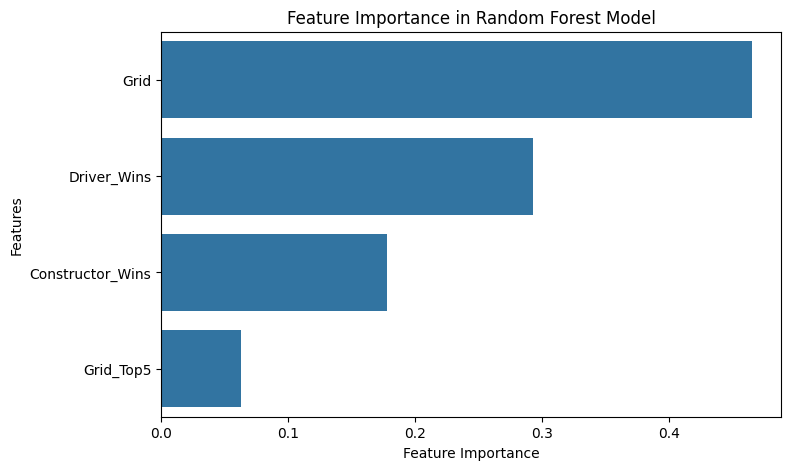

In [147]:
# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

### **Step 5: Testing on Real Race Data**

Predicted Winner: VER
Actual Winner: VER Correct

Predictions vs Actual Results for Bahrain Grand Prix
   Driver  Grid  Position  Predicted_Win_Prob
0     VER     1         1               0.736
3     LEC     2         4               0.014
11    MAG    15        12               0.000
18    BOT    16        19               0.000
17    GAS    20        18               0.000
16    OCO    19        17               0.000
15    HUL    10        16               0.000
14    ALB    13        15               0.000
13    TSU    11        14               0.000
12    RIC    14        13               0.000
10    ZHO    17        11               0.000
1     PER     5         2               0.000
9     STR    12        10               0.000
8     ALO     6         9               0.000
7     PIA     8         8               0.000
6     HAM     9         7               0.000
5     NOR     7         6               0.000
4     RUS     3         5               0.000
2     SAI     4        

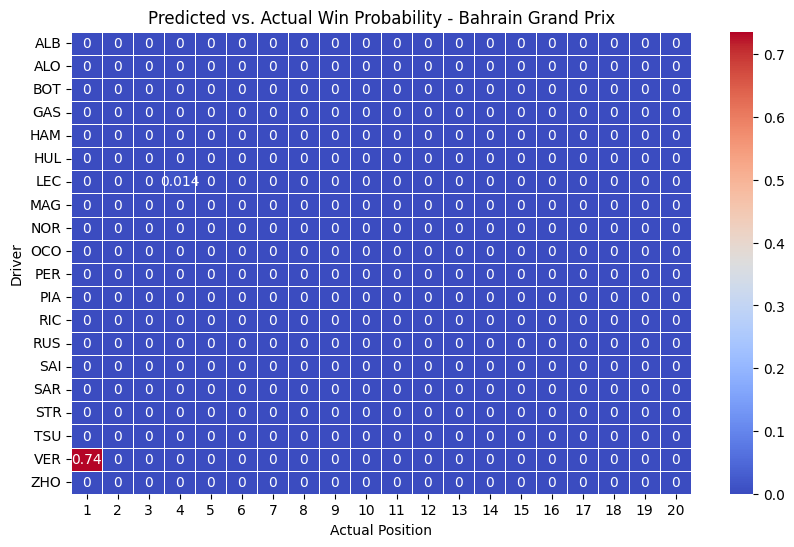

,Year,Round,Race,Circuit,Driver,Constructor,Grid,Position,Points,Status,Win,Grid_Top5,Constructor_Wins,Driver_Wins,Predicted_Win_Prob
0,2024,1,Bahrain Grand Prix,Bahrain International Circuit,VER,Red Bull,1,1,26.0,Finished,1,1,1,1,0.736
3,2024,1,Bahrain Grand Prix,Bahrain International Circuit,LEC,Ferrari,2,4,12.0,Finished,0,1,0,0,0.014
11,2024,1,Bahrain Grand Prix,Bahrain International Circuit,MAG,Haas F1 Team,15,12,0.0,+1 Lap,0,0,0,0,0.000
18,2024,1,Bahrain Grand Prix,Bahrain International Circuit,BOT,Sauber,16,19,0.0,+1 Lap,0,0,0,0,0.000
17,2024,1,Bahrain Grand Prix,Bahrain International Circuit,GAS,Alpine F1 Team,20,18,0.0,+1 Lap,0,0,0,0,0.000
16,2024,1,Bahrain Grand Prix,Bahrain International Circuit,OCO,Alpine F1 Team,19,17,0.0,+1 Lap,0,0,0,0,0.000
15,2024,1,Bahrain Grand Prix,Bahrain International Circuit,HUL,Haas F1 Team,10,16,0.0,+1 Lap,0,0,0,0,0.000
14,2024,1,Bahrain Grand Prix,Bahrain International Circuit,ALB,Williams,13,15,0.0,+1 Lap,0,0,0,0,0.000
13,2024,1,Bahrain Grand Prix,Bahrain International Circuit,TSU,RB F1 Team,11,14,0.0,+1 Lap,0,0,0,0,0.000
12,2024,1,Bahrain Grand Prix,Bahrain International Circuit,RIC,RB F1 Team,14,13,0.0,+1 Lap,0,0,0,0,0.000


In [146]:
# Function to test model on a specific race and visualize predictions
def test_race_prediction(year, round_num):
    race_data = fetch_race_data(year)
    specific_race = race_data[race_data['Round'] == str(round_num)].copy()

    if specific_race.empty:
        print("Race data not found!")
        return

    # Ensure required features exist
    specific_race['Win'] = (specific_race['Position'] == 1).astype(int)
    specific_race['Grid_Top5'] = (specific_race['Grid'] <= 5).astype(int)
    specific_race['Constructor_Wins'] = specific_race.groupby(['Constructor'])['Win'].transform('sum')
    specific_race['Driver_Wins'] = specific_race.groupby(['Driver'])['Win'].transform('sum')

    X_race = specific_race[['Grid', 'Grid_Top5', 'Constructor_Wins', 'Driver_Wins']]

    # Predict probabilities
    probabilities = rf_model.predict_proba(X_race)[:, 1]  # Probability of winning

    # Assign probabilities to the specific race dataset
    specific_race['Predicted_Win_Prob'] = probabilities

    # Sort by probability to get the highest predicted winner
    specific_race = specific_race.sort_values(by='Predicted_Win_Prob', ascending=False)

    predicted_winner = specific_race.iloc[0]['Driver']
    actual_winner = specific_race[specific_race['Win'] == 1]['Driver'].values[0]

    print(f"Predicted Winner: {predicted_winner}")
    print(f"Actual Winner: {actual_winner} {'Correct' if predicted_winner == actual_winner else 'Incorrect'}")

    print("\nPredictions vs Actual Results for", specific_race['Race'].iloc[0])
    print(specific_race[['Driver', 'Grid', 'Position', 'Predicted_Win_Prob']])

    # Heatmap visualization
    plt.figure(figsize=(10, 6))
    heatmap_data = specific_race.pivot(index='Driver', columns='Position', values='Predicted_Win_Prob').fillna(0)
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.xlabel("Actual Position")
    plt.ylabel("Driver")
    plt.title(f"Predicted vs. Actual Win Probability - {specific_race['Race'].iloc[0]}")
    plt.show()

    return specific_race

# Example: Test on a specific 2024 race
test_race_prediction(2024, 1)
